# Bitpredict

We want to create a time series model to predict the price of Bitcoin.  This project is not something I have used to deploy anything in the world, it was a hands-on work with a time series project.  This code is a project adapted from the Udemy course TensorFlow Developer Certificate in 2023: Zero to Mastery.

## Access our Data

In [ ]:
!pip install cryptocmd
from cryptocmd import CmcScraper
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
scraper = CmcScraper("BTC")

In [ ]:
df = scraper.get_dataframe(date_as_index=True)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-06-04,27075.122073,27407.018570,26968.224141,27119.067193,9.360912e+09,5.259202e+11
2023-06-03,27252.323333,27317.051854,26958.003740,27075.129398,8.385597e+09,5.250436e+11
2023-06-02,26824.556981,27303.861687,26574.644421,27249.588949,1.483741e+10,5.284044e+11
2023-06-01,27218.412376,27346.105483,26671.721156,26819.973220,1.467897e+10,5.200450e+11
2023-05-31,27700.530089,27831.677804,26866.453944,27219.658608,1.565637e+10,5.277732e+11


In [ ]:
len(df)

3690

In [ ]:
df_btc = df[::-1]

In [ ]:
df_btc.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.300003,135.979996,132.100006,134.210007,0.0,1.488567e+09
2013-04-29,134.444000,147.488007,134.000000,144.539993,0.0,1.603769e+09
2013-04-30,144.000000,146.929993,134.050003,139.000000,0.0,1.542813e+09
2013-05-01,139.000000,139.889999,107.720001,116.989998,0.0,1.298955e+09
2013-05-02,116.379997,125.599998,92.281898,105.209999,0.0,1.168517e+09


In [ ]:
btc_price = pd.DataFrame(df_btc['Close']).rename(columns={'Close': "Price"})
btc_price.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


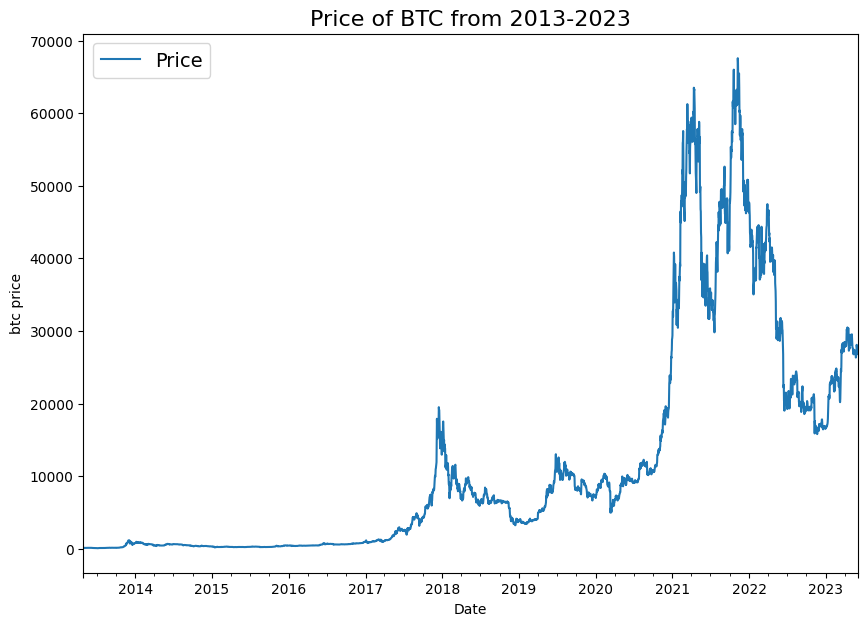

In [ ]:
import matplotlib.pyplot as plt
btc_price.plot(figsize=(10,7))
plt.ylabel("btc price")
plt.title("Price of BTC from 2013-2023", fontsize=16)
plt.legend(fontsize=14)


## Train and Test Split

In [ ]:
split_size = int(0.8*len(btc_price))

In [ ]:
timesteps = btc_price.index.to_numpy()

In [ ]:
prices = btc_price["Price"].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

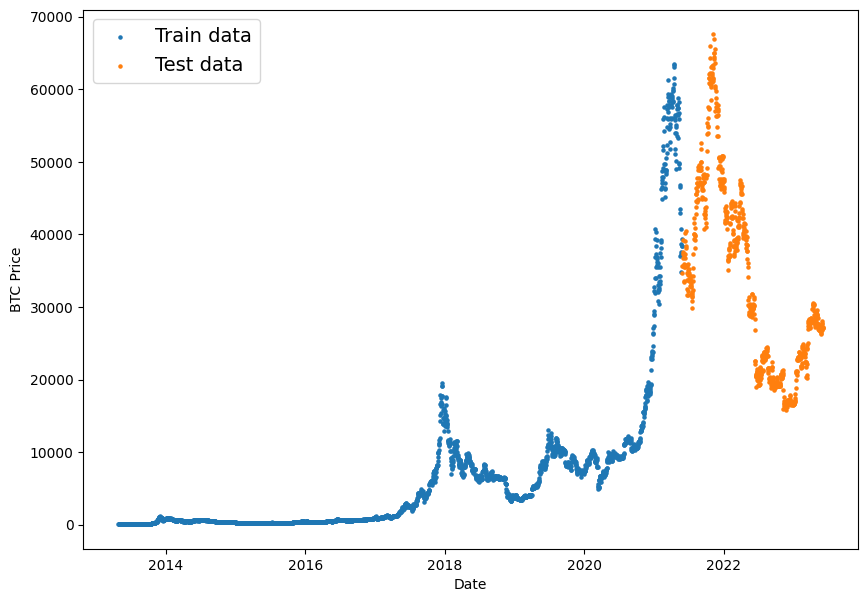

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s = 5, label="Train data")
plt.scatter(X_test, y_test, s = 5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [ ]:
def plot_ts_data(timesteps, values, format=".", start = 0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)




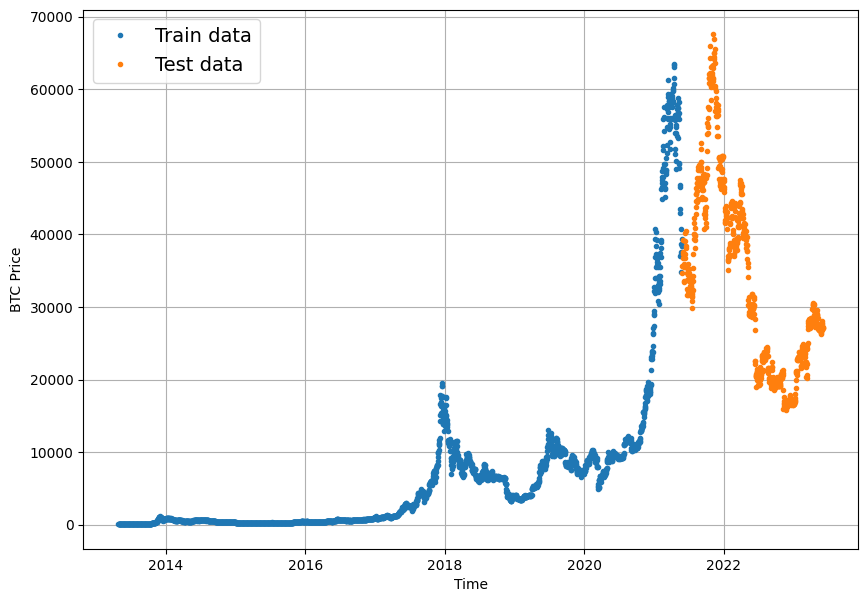

In [ ]:
plt.figure(figsize=(10,7))
plot_ts_data(timesteps=X_train, values=y_train, label="Train data")
plot_ts_data(timesteps=X_test, values=y_test, label="Test data")

## Model 0: Creating a baseline

In [ ]:
naive_forecast = y_test[:-1]

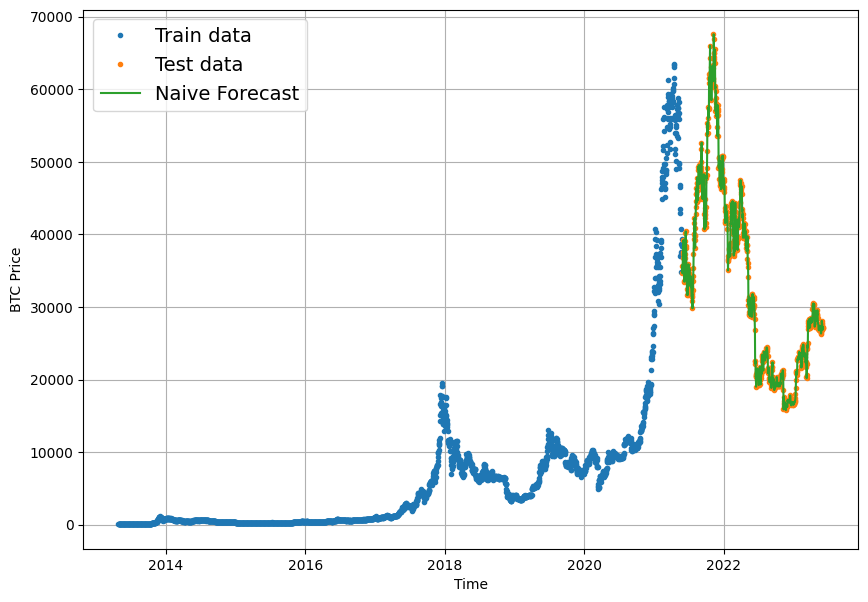

In [ ]:
plt.figure(figsize=(10,7))
plot_ts_data(timesteps=X_train, values=y_train, label="Train data")
plot_ts_data(timesteps=X_test, values=y_test, label="Test data")
plot_ts_data(timesteps=X_test[1:], values=naive_forecast, format="-",label="Naive Forecast")

In [ ]:
import tensorflow as tf

In [ ]:
def mean_abs_scaled_err(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))

  return mae / mae_naive_no_season

In [ ]:
mean_abs_scaled_err(y_test[1:], naive_forecast).numpy()

1.0004920363435956

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_abs_scaled_err(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)


  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 794.1041,
 'mse': 1419816.6,
 'rmse': 1191.5605,
 'mape': 2.3178527,
 'mase': 1.0004921}

In [ ]:
y_train

array([  134.21000671,   144.53999329,   139.        , ...,
       38402.22385137, 39294.19738214, 38436.96853505])

In [ ]:
prices[:10]

array([134.21000671, 144.53999329, 139.        , 116.98999786,
       105.20999908,  97.75      , 112.5       , 115.91000366,
       112.30000305, 111.5       ])

In [ ]:
HORIZON = 1
WINDOW_SIZE=7

In [ ]:
def get_labeled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0,1,2,3,4,5,6,7] -> Output: ([0,1,2,3,4,5,6],[7])
  """
  return x[:,:-horizon], x[:,-horizon]

In [ ]:
test_window, test_label = get_labeled_windows(tf.expand_dims(tf.range(8), axis = 0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [ ]:
import numpy as np
def make_windows(x, window_size = WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labeled windows of window_size with horizon size labels.
  """
  window_step = np.expand_dims(np.arange(window_size+horizon), axis = 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labeled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3683, 3683)

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i-3]}-> Label: {full_labels[i-3]}")

Window: [26719.29098462 26868.35381843 28085.64736075 27745.88444355
 27702.34877478 27219.65860811 26819.97321971]-> Label: 27249.588949088356
Window: [26868.35381843 28085.64736075 27745.88444355 27702.34877478
 27219.65860811 26819.97321971 27249.58894909]-> Label: 27075.129398442477
Window: [28085.64736075 27745.88444355 27702.34877478 27219.65860811
 26819.97321971 27249.58894909 27075.12939844]-> Label: 27119.067193126313


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test split
  """
  splits_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2952, 731, 2952, 731)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[134.21000671, 144.53999329, 139.        , 116.98999786,
         105.20999908,  97.75      , 112.5       ],
        [144.53999329, 139.        , 116.98999786, 105.20999908,
          97.75      , 112.5       , 115.91000366],
        [139.        , 116.98999786, 105.20999908,  97.75      ,
         112.5       , 115.91000366, 112.30000305],
        [116.98999786, 105.20999908,  97.75      , 112.5       ,
         115.91000366, 112.30000305, 111.5       ],
        [105.20999908,  97.75      , 112.5       , 115.91000366,
         112.30000305, 111.5       , 113.56600189]]),
 array([115.91000366, 112.30000305, 111.5       , 113.56600189,
        112.66999817]))

## Model 1: First Dense Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON,activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

In [ ]:
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
24/24 [==============================] - 11s 19ms/step - loss: 2665.1541 - mae: 2665.1541 - mse: 43235328.0000 - val_loss: 4823.9863 - val_mae: 4823.9863 - val_mse: 29497838.0000
Epoch 2/100
24/24 [==============================] - 0s 11ms/step - loss: 441.1978 - mae: 441.1978 - mse: 1314668.8750 - val_loss: 1171.1381 - val_mae: 1171.1381 - val_mse: 2713923.5000
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 303.4418 - mae: 303.4418 - mse: 639489.2500 - val_loss: 1260.1185 - val_mae: 1260.1185 - val_mse: 3028607.7500
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 294.0215 - mae: 294.0215 - mse: 609866.1250 - val_loss: 1064.5697 - val_mae: 1064.5697 - val_mse: 2289061.0000
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 261.2969 - mae: 261.2969 - mse: 506234.5000 - val_loss: 1022.6049 - val_mae: 1022.6049 - val_mse: 2133597.7500
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - los

In [ ]:
model_1.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 2ms/step - loss: 881.9916 - mae: 881.9916 - mse: 1645609.0000


[881.9916381835938, 881.9916381835938, 1645609.0]

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predications on input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

23/23 [==============================] - 0s 1ms/step


(731,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([39464.652, 37621.867, 36310.37 , 36167.008, 34058.008, 33905.293,
        37159.535, 37052.746, 37865.26 , 36246.227], dtype=float32)>)

In [ ]:
test_labels[:10]

array([36894.40532994, 35551.95872588, 35862.37772747, 33560.70783776,
       33472.63174808, 37345.12148619, 36702.59937466, 37334.39952553,
       35552.51714847, 39097.86089667])

In [ ]:
test_labels.shape, model_1_preds.shape

((731,), TensorShape([731]))

In [ ]:
model_1_results = evaluate_preds(test_labels, model_1_preds)
model_1_results

{'mae': 881.99164,
 'mse': 1645608.8,
 'rmse': 1282.8129,
 'mape': 2.6195707,
 'mase': 1.1178596}

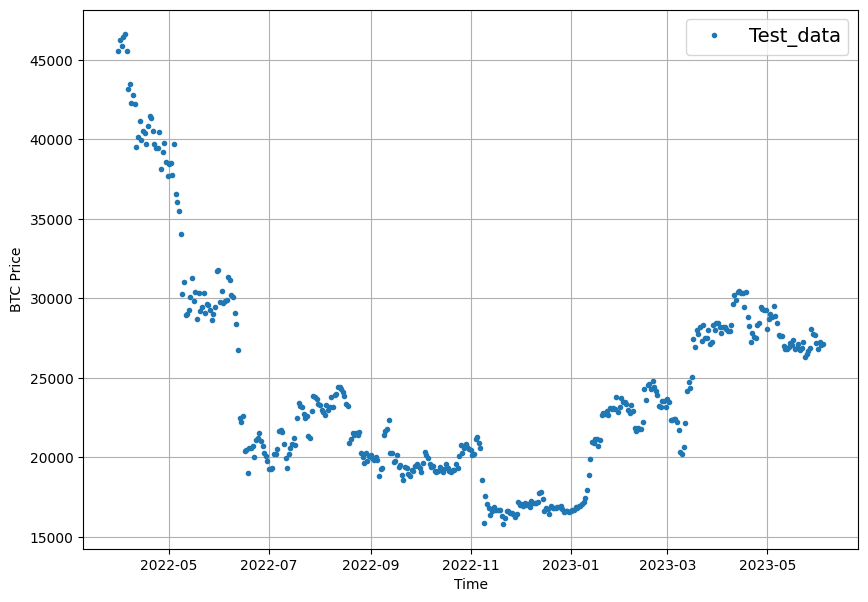

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_ts_data(timesteps=X_test[-len(test_windows):], values=test_labels, start=offset, label="Test_data")

## Model 2: Dense With a Different Window

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon= HORIZON)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
train_windows[1]

array([144.53999329, 139.        , 116.98999786, 105.20999908,
        97.75      , 112.5       , 115.91000366, 112.30000305,
       111.5       , 113.56600189, 112.66999817, 117.19999695,
       115.24299622, 115.        , 117.98000336, 111.5       ,
       114.22000122, 118.76000214, 123.01499939, 123.4980011 ,
       121.98999786, 122.        , 122.87999725, 123.88899994,
       126.69999695, 133.19999695, 131.97999573, 133.47999573,
       129.74499512, 129.        ])

In [ ]:
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON,activation="linear")
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
24/24 [==============================] - 1s 11ms/step - loss: 1765.9187 - mae: 1765.9187 - mse: 18916490.0000 - val_loss: 4905.1270 - val_mae: 4905.1270 - val_mse: 37986976.0000
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 642.6586 - mae: 642.6586 - mse: 2749835.0000 - val_loss: 2188.0579 - val_mae: 2188.0579 - val_mse: 8067127.0000
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 398.1117 - mae: 398.1117 - mse: 1153901.1250 - val_loss: 1407.9978 - val_mae: 1407.9978 - val_mse: 3868029.5000
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 384.5648 - mae: 384.5648 - mse: 1052673.2500 - val_loss: 1363.1924 - val_mae: 1363.1924 - val_mse: 3625353.0000
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 405.2143 - mae: 405.2143 - mse: 1182289.8750 - val_loss: 2258.5986 - val_mae: 2258.5986 - val_mse: 8083375.5000
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - los

In [ ]:
model_2.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 3ms/step - loss: 1693.2844 - mae: 1693.2844 - mse: 4410685.5000


[1693.284423828125, 1693.284423828125, 4410685.5]

In [ ]:
model_2_preds = make_preds(model_2, test_windows)

23/23 [==============================] - 0s 1ms/step


In [ ]:
model_2_results = evaluate_preds(test_labels, model_2_preds)
model_2_results

{'mae': 1693.2845,
 'mse': 4410684.5,
 'rmse': 2100.1628,
 'mape': 5.131954,
 'mase': 2.2078373}

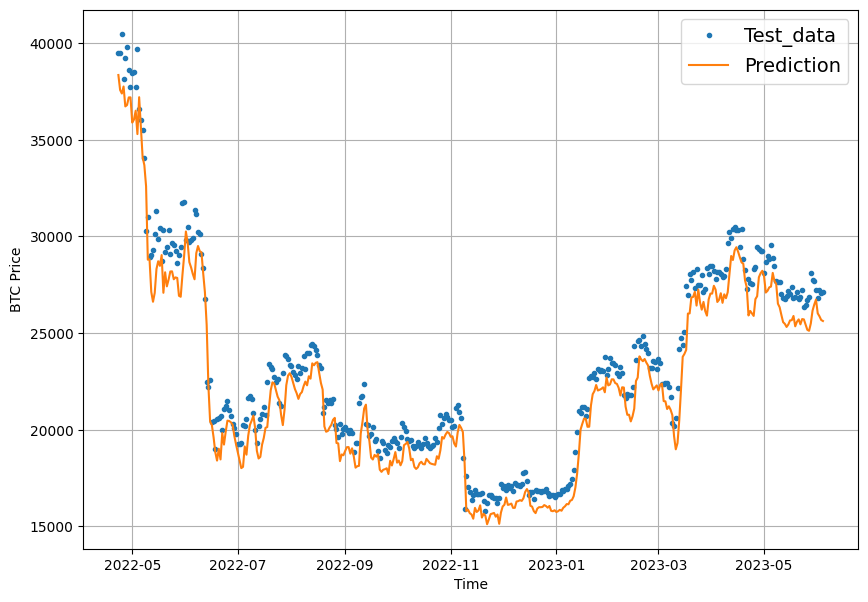

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_ts_data(timesteps=X_test[-len(test_windows):], values=test_labels, start=offset, label="Test_data")
plot_ts_data(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-",label="Prediction")

##Model 3: Using Convolution

In [ ]:
HORIZON = 1
WINDOW_SIZE =7


In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon=HORIZON)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
train_windows[0].shape

(7,)

In [ ]:
x = tf.constant(train_windows[0])
print(x)

tf.Tensor(
[134.21000671 144.53999329 139.         116.98999786 105.20999908
  97.75       112.5       ], shape=(7,), dtype=float64)


In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [ ]:
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original value with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original value with expanded shape: 
 [[134.21]
 [144.54]
 [139.  ]
 [116.99]
 [105.21]
 [ 97.75]
 [112.5 ]]


In [ ]:
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides =1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)

], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

hist_4 = model_4.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose=0,
            validation_data=(test_windows,test_labels))

In [ ]:
model_4.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 4ms/step - loss: 28147.5703


28147.5703125

In [ ]:
model_4_preds = make_preds(model_4, test_windows)

23/23 [==============================] - 0s 3ms/step


In [ ]:
model_4_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_4_preds)

## Model 4: LSTM

In [ ]:
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
24/24 [==============================] - 3s 15ms/step - loss: 4644.2739 - val_loss: 8522.1973
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 675.5593 - val_loss: 1917.3719
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 407.3839 - val_loss: 1416.8289
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 358.6953 - val_loss: 1377.9402
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 341.1184 - val_loss: 1422.3541
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 341.8515 - val_loss: 1282.5750
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 338.6310 - val_loss: 1282.2783
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 336.2578 - val_loss: 1288.0070
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 332.2968 - val_loss: 1509.2450
Epoch 10/100
24/24 [==============================] - 0s 6ms/s

In [ ]:
model_5_preds = make_preds(model_5, test_windows)

23/23 [==============================] - 0s 2ms/step


In [ ]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 1039.1719,
 'mse': 2100166.8,
 'rmse': 1449.1952,
 'mape': 3.1141634,
 'mase': 1.3170741}

In [ ]:
model_1_results

{'mae': 881.99164,
 'mse': 1645608.8,
 'rmse': 1282.8129,
 'mape': 2.6195707,
 'mase': 1.1178596}

## Making a Multivariate Time Series Dataset

In [ ]:
btc_price.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


In [ ]:
#My goal is to add data on the halving dates of bitcoin as a feature
block_reward_1 = 50 # 3 January 2009, but this is before our data so we ignore
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")


In [ ]:
block_reward_2_days = (block_reward_3_datetime-btc_price.index[0]).days
block_reward_3_days = (block_reward_4_datetime-btc_price.index[0]).days
block_reward_2_days, block_reward_3_days

(1168, 2577)

In [ ]:
btc_price_block = btc_price.copy()
btc_price_block["block_reward"] = None
btc_price_block.iloc[:block_reward_2_days,-1]= block_reward_2
btc_price_block.iloc[block_reward_2_days: block_reward_3_days,-1]= block_reward_3
btc_price_block.iloc[block_reward_3_days:,-1]= block_reward_4
btc_price_block.tail()

,Price,block_reward
Date,,
2023-05-31,27219.658608,6.25
2023-06-01,26819.973220,6.25
2023-06-02,27249.588949,6.25
2023-06-03,27075.129398,6.25
2023-06-04,27119.067193,6.25


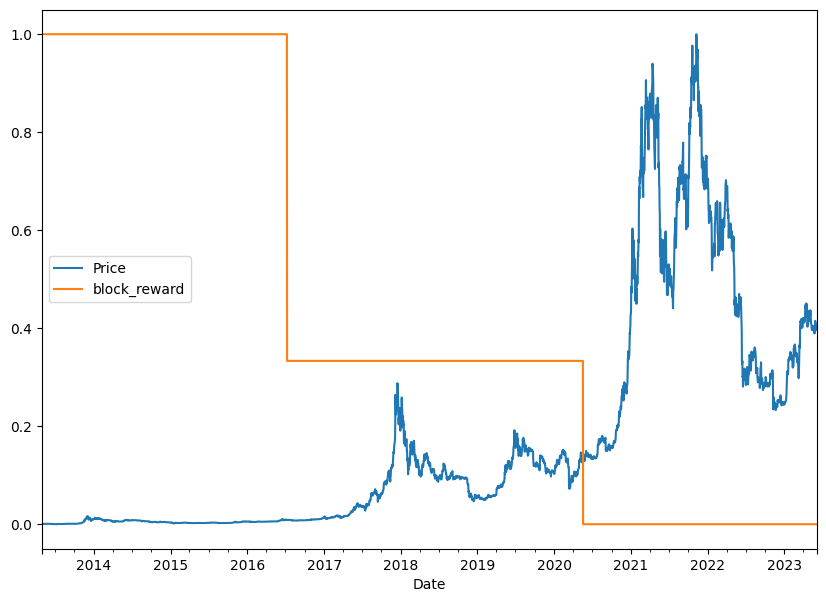

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block = pd.DataFrame(minmax_scale(btc_price_block[["Price", "block_reward"]]),
                                  columns = btc_price_block.columns,
                                  index = btc_price_block.index)
scaled_price_block.plot(figsize=(10,7));

## Preparing our Multivariate Data

In [ ]:
btc_price_windowed = btc_price_block.copy()

for i in range(WINDOW_SIZE):
  btc_price_windowed[f"Price+{i+1}"] = btc_price_windowed["Price"].shift(periods=i+1)

btc_price_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-04-28,134.210007,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,25,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,25,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,25,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,25,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN
2013-05-03,97.750000,25,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN
2013-05-04,112.500000,25,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007,NaN
2013-05-05,115.910004,25,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,112.300003,25,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993


In [ ]:
btc_price_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-04-28,134.210007,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,25,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,25,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,25,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,25,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN


In [ ]:
X = btc_price_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = btc_price_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-05-05,25.0,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,25.0,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993
2013-05-07,25.0,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000
2013-05-08,25.0,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998
2013-05-09,25.0,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999


In [ ]:
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2946, 2946, 737, 737)

## Model 5: Multivariate Model 1

In [ ]:
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_Dense_multivariate")

model_6.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test,y_test))

Epoch 1/100
24/24 [==============================] - 1s 12ms/step - loss: 2456.1833 - val_loss: 5512.2573
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 514.6182 - val_loss: 1824.2448
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 349.5893 - val_loss: 1338.5513
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 335.4925 - val_loss: 1304.6769
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 379.3008 - val_loss: 1311.2128
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 315.8313 - val_loss: 1220.1967
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 309.6674 - val_loss: 1218.9108
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 293.3700 - val_loss: 1155.7793
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 284.7255 - val_loss: 1396.5968
Epoch 10/100
24/24 [==============================] - 0s 6ms/s

In [ ]:
model_6_preds = tf.squeeze(model_6.predict(X_test))

24/24 [==============================] - 0s 1ms/step


In [ ]:
model_6_results = evaluate_preds(y_test,model_6_preds)
model_6_results

{'mae': 1030.7432,
 'mse': 2044609.1,
 'rmse': 1429.8983,
 'mape': 3.0398233,
 'mase': 1.2986338}

## Model 6: N-Beats Algorithm

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation ="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:,-self.horizon:]
    return backcast, forecast

In [ ]:
dummy_nbeats = NBeatsBlock(input_size = WINDOW_SIZE,
                           theta_size = WINDOW_SIZE + HORIZON,
                           horizon=HORIZON,
                           n_neurons=128,
                           n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis =0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.11195578  0.7005705  -0.5974757   0.7920905   0.37729874 -0.71670747
 -0.18821804]
Forecast: 0.8319001197814941


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
btc_price_nbeats = btc_price.copy()
for i in range(WINDOW_SIZE):
  btc_price_nbeats[f"Price+{i+1}"] = btc_price["Price"].shift(periods = i+1)
btc_price_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-04-28,134.210007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN


In [ ]:
X = btc_price_nbeats.dropna().drop("Price", axis=1).astype(np.float32)
y = btc_price_nbeats.dropna()["Price"].astype(np.float32)
X.head()

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2013-05-05,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993
2013-05-07,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000
2013-05-08,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998
2013-05-09,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999


In [ ]:
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = 7
THETA_SIZE = 8


In [ ]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = layers.subtract([tensor_1, tensor_2])

added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} and {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] and [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [ ]:
%%time

nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE), name= "stack_input")

residuals, forecast = nbeats_block_layer(stack_input)

for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size = INPUT_SIZE,
      theta_size = THETA_SIZE,
      horizon=HORIZON,
      n_neurons = N_NEURONS,
      n_layers= N_LAYERS,
      name = f"NBeatsBlock_{i}"
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBeats")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 1171: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1378: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1478: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 5min 40s, sys: 6.86 s, total: 5min 46s
Wall time: 7min 2s


In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 40ms/step - loss: 816.3823


816.3822631835938

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)

1/1 [==============================] - 1s 1s/step


In [ ]:
model_7_results = evaluate_preds(y_test,model_7_preds)
model_7_results

{'mae': 816.38226,
 'mse': 1492202.1,
 'rmse': 1221.5573,
 'mape': 2.3825462,
 'mase': 1.0285604}

In [ ]:
model_1_results

{'mae': 881.99164,
 'mse': 1645608.8,
 'rmse': 1282.8129,
 'mape': 2.6195707,
 'mase': 1.1178596}

##Model 7: Ensembling

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

In [ ]:
def get_ensemble_model(horizon=HORIZON,
                       train_data = train_dataset,
                       test_data=test_dataset,
                       num_iter=10,
                       num_epochs=1000,
                       loss_fn=["mae","mse","mape"]):
  """
  returns a list of num_iter models trained on each of the loss functions in loss_fn

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10*len(["mae","mse","mape"])
  """
  ensemble_models=[]

  for i in range(num_iter):
    for loss_function in loss_fn:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      model.compile(loss=loss_function,
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

      ensemble_models.append(model)
  return ensemble_models

In [ ]:
%%time

ensemble_models = get_ensemble_model(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 405: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 577: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 677: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 156: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 267: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 367: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 834: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 934: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 330: ReduceLROnPl

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds=[]
  for model in ensemble_models:
    preds=model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 44ms/step
CPU times: user 696 ms, sys: 34 ms, total: 730 ms
Wall time: 800 ms


<tf.Tensor: shape=(15, 737), dtype=float32, numpy=
array([[33711.727, 31223.002, 32891.766, ..., 24966.195, 25062.139,
        25222.645],
       [35978.91 , 35038.297, 35239.03 , ..., 26899.314, 27295.795,
        27060.79 ],
       [35750.9  , 34601.977, 35664.023, ..., 26807.062, 27252.371,
        27024.863],
       ...,
       [35981.277, 34235.81 , 35390.477, ..., 26717.908, 27088.893,
        27148.549],
       [36055.17 , 34086.27 , 35105.51 , ..., 26778.932, 27087.285,
        27074.617],
       [35478.15 , 35033.316, 35433.14 , ..., 26800.766, 27227.816,
        27018.05 ]], dtype=float32)>

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)

In [ ]:
ensemble_results_mean = evaluate_preds(y_test, ensemble_mean)
ensemble_results_mean

{'mae': 807.05176,
 'mse': 1462846.1,
 'rmse': 1209.4817,
 'mape': 2.3578086,
 'mase': 1.0168049}

In [ ]:
ensemble_results_median = evaluate_preds(y_test, ensemble_median)
ensemble_results_median

{'mae': 799.36865,
 'mse': 1438969.4,
 'rmse': 1199.5706,
 'mape': 2.3328092,
 'mase': 1.0071249}

### Plotting the Prediction Intervals

In [ ]:
def get_upper_lower(preds):
  std = tf.math.reduce_std(preds,axis=0)
  interval = 1.96 * std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean-interval, preds_mean+interval
  return lower, upper

In [ ]:
lower, upper = get_upper_lower(preds=ensemble_preds)


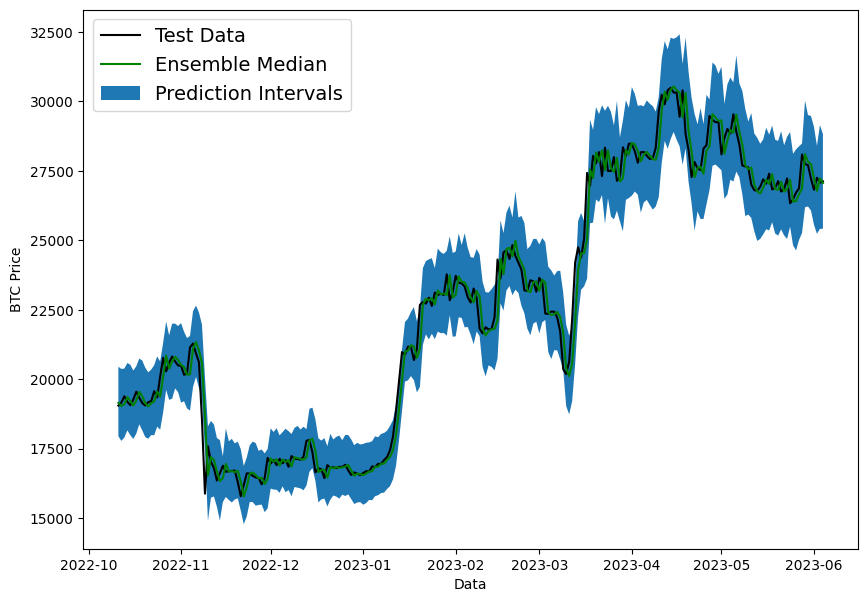

In [ ]:
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "-k", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "g", label="Ensemble Median")
plt.xlabel("Data")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label = "Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

## Model 8: Making Future Predictions

In [ ]:
btc_price_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-04-28,134.210007,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,25,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,25,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,25,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,25,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN


In [ ]:
X_all = btc_price_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = btc_price_windowed.dropna()["Price"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))

BATCH_SIZE=1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

model_9.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

In [ ]:
INTO_FUTURE =14

In [ ]:
def make_future_forecasts(values, model, into_future =INTO_FUTURE, window_size=WINDOW_SIZE):
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats
  """
  future_forecast =[]
  last_window = values[-window_size:]
  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window,axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction {tf.squeeze(future_pred).numpy()}")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-window_size:]
  return future_forecast

In [ ]:
future_forc = make_future_forecasts(y_all, model_9)

1/1 [==============================] - 0s 28ms/step
Predicting on: 
 [27745.88444355 27702.34877478 27219.65860811 26819.97321971
 27249.58894909 27075.12939844 27119.06719313] -> Prediction 27876.0
1/1 [==============================] - 0s 32ms/step
Predicting on: 
 [27702.34877478 27219.65860811 26819.97321971 27249.58894909
 27075.12939844 27119.06719313 27876.        ] -> Prediction 27750.77734375
1/1 [==============================] - 0s 27ms/step
Predicting on: 
 [27219.65860811 26819.97321971 27249.58894909 27075.12939844
 27119.06719313 27876.         27750.77734375] -> Prediction 27286.244140625
1/1 [==============================] - 0s 27ms/step
Predicting on: 
 [26819.97321971 27249.58894909 27075.12939844 27119.06719313
 27876.         27750.77734375 27286.24414062] -> Prediction 27093.7265625
1/1 [==============================] - 0s 29ms/step
Predicting on: 
 [27249.58894909 27075.12939844 27119.06719313 27876.
 27750.77734375 27286.24414062 27093.7265625 ] -> Prediction 

In [ ]:
def get_future_dates(start_date, into_future=INTO_FUTURE, offset = 1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
last_timestep = btc_price.index[-1]

In [ ]:
next_time_steps = get_future_dates(start_date= last_timestep)
next_time_steps

array(['2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08',
       '2023-06-09', '2023-06-10', '2023-06-11', '2023-06-12',
       '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
       '2023-06-17', '2023-06-18'], dtype='datetime64[D]')

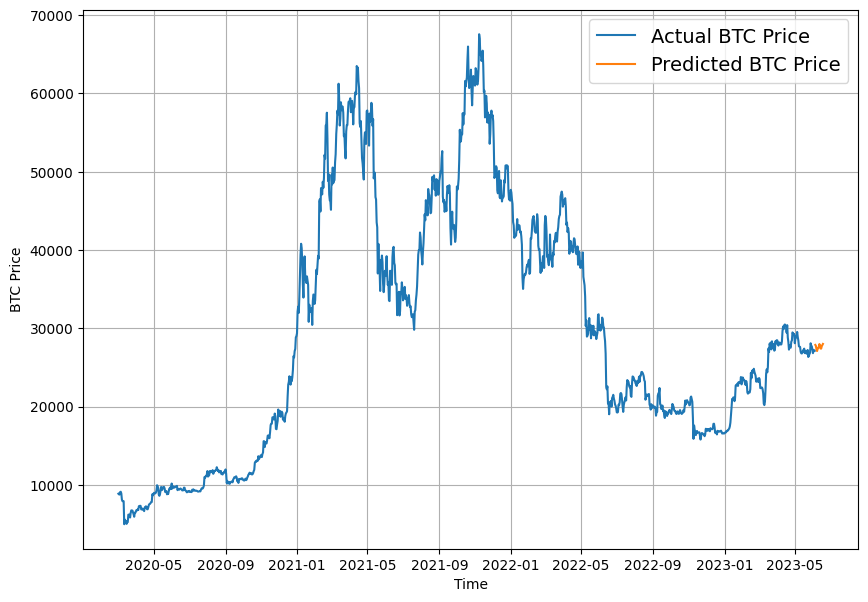

In [ ]:
plt.figure(figsize=(10,7))
plot_ts_data(btc_price.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_ts_data(next_time_steps, future_forc, format="-", label="Predicted BTC Price")